# Transformée de Laplace inverse

## Introduction

La résolution d'équations différentielles linéaires peut s'effectuer en s'aidant de la transformée de Laplace. Via cette méthode, on accède dans un premier temps à la transformée de Laplace de la solution, qui se présente pour l'essentiel sous la forme d'une fraction rationnelle d'une variable complexe $p$.

Pour revenir à l'expression temporelle de la solution, il faut procéder à la **décomposition en éléments simples** de la fraction rationnelle en $p$, de sorte qu'apparaissent des termes élémentaires de la forme $\dfrac{K}{(p-a)^n}$ (dans le corps des complexes) pour lesquels l'expression temporelle associée $K\dfrac{t^{n-1}e^{at}\theta(t)}{(n-1)!}$ est connue.

L'idée ici est d'illustrer les méthodes de calcul via le package **sympy** de calcul symbolique. Mais il reste préférable de pouvoir **mener ces calculs avec un crayon et un papier**.

La validation s'effectuera avec la fonction **impulse** du package **scipy.signal**.

## Les packages utiles

In [1]:
import sympy as sp
import numpy as np
from scipy.signal import impulse
import matplotlib.pyplot as plt
from IPython.display import display

## Définition de $H(p)$ sous forme littérale

In [2]:
p, t, G = sp.symbols('p, t, G')
Gn = [(G, 5)]
P = sp.IndexedBase('P')
Z = sp.IndexedBase('Z')
Pn = [(P[0], -0.5), (P[1], -0.8), (P[2], -0.7)]
OPn = [1, 3, 1]
Zn = [(Z[0], 0.1), (Z[1], 0.2)]
OZn = [1, 1]
# Autres essais à tester
# Pn = [(P[0], 0.0), (P[1], -0.8), (P[2], -0.7)]
# OPn = [2, 2, 1]
# Zn = [(Z[0], 0.1), (Z[1], 0.2)]
# OZn = [1, 1]
# Pn = [(P[0], -0.5), (P[1], -0.8), (P[2], -0.7)]
# OPn = [1, 3, 1]
# Zn = [(Z[0], 0.0), (Z[1], 0.2)]
# OZn = [2, 1]
# Pn = [(P[0], -0.1+1j), (P[1], -0.1-1j), (P[2], -0.7)]
# OPn = [1, 1, 3]
# Zn = [(Z[0], 0.1), (Z[1], 0.2)]
# OZn = [2, 1]

In [3]:
H = Gn[0][0]
for k in range(len(Pn)):
    H = H/(p - Pn[k][0])**OPn[k]
for k in range(len(Zn)):
    H = H*(p - Zn[k][0])**OZn[k]
display(H)
display(H.subs(Pn).subs(Zn).subs(Gn))

G*(p - Z[0])*(p - Z[1])/((p - P[0])*(p - P[1])**3*(p - P[2]))

5*(p - 0.2)*(p - 0.1)/((p + 0.5)*(p + 0.7)*(p + 0.8)**3)

## La fonction qui travaille sur l'expression numérique de $H(p)$

In [4]:
def inv_lapl(Gn, Zn, OZn, Pn, OPn, p, t):
    A = sp.IndexedBase('A')
    y = sp.symbols('y')
    An, h, tl = [], 0, 0
    polyP = Gn[0][1]
    for m in range(len(Zn)):
        polyP = polyP*(p - Zn[m][1])**OZn[m]
    for k in range(len(Pn)):
        display(Pn[k][0])
        polyB = 1
        for m in range(len(Pn)):
            if m != k:
                polyB = polyB*(p - Pn[m][1])**OPn[m]
        polyB = polyB.subs(p, y+Pn[k][1])
        polyR = polyP.subs(p, y+Pn[k][1])
        polyQ = 0
        for m in range(OPn[k]):
            q = sp.Poly(polyR, y).coeffs()[-1]/sp.Poly(polyB, y).coeffs()[-1]
            polyQ = polyQ+q*y**m
            polyR = polyR - q*polyB*y**m
            test_err_arithm = complex(sp.Poly(polyR, y).coeff_monomial(y**m))
            if test_err_arithm != 0.0:
                print(
                    f'correction nécéssaire sur la division de polynômes (test_err_arithm={test_err_arithm})')
                display(sp.Poly(polyR, y))
                coeff = sp.Poly(polyR, y).coeffs()
                polyR = 0
                for mR in range(len(coeff)-1):
                    polyR = polyR + coeff[mR]*y**(m+len(coeff)-1-mR)
                display(sp.Poly(polyR, y))
        for m in range(OPn[k]):
            if OPn[k] != 1:
                Anum = sp.Poly(polyQ, y).coeffs()
                print('degré', m+1, 'coeff', Anum[m].simplify())
                An.append((A[k, m+1], Anum[m].simplify()))
            else:
                Anum = polyQ
                print('degré', m+1, 'coeff', Anum.simplify())
                An.append((A[k, m+1], Anum.simplify()))
            h = h+A[k, m+1]*t**m*sp.exp(Pn[k][0]*t)/sp.factorial(m)
            tl = tl+A[k, m+1]/(p - Pn[k][0])**(m+1)
    return An, h, tl

## Test de la fonction pour obtenir $h(t)$ sous forme littérale, puis numérique

In [5]:
An, h, tl = inv_lapl(Gn, Zn, OZn, Pn, OPn, p, t)
display(h)
display(h.subs(An).subs(Pn))
display(tl)
display(tl.subs(An).subs(Pn))

P[0]

degré 1 coeff 388.888888888889


P[1]

degré 1 coeff 17611.1111111111
degré 2 coeff 1683.33333333333
degré 3 coeff 150.000000000000


P[2]

degré 1 coeff -18000.0000000000


t**2*exp(t*P[1])*A[1, 3]/2 + t*exp(t*P[1])*A[1, 2] + exp(t*P[0])*A[0, 1] + exp(t*P[1])*A[1, 1] + exp(t*P[2])*A[2, 1]

74.9999999999999*t**2*exp(-0.8*t) + 1683.33333333333*t*exp(-0.8*t) + 17611.1111111111*exp(-0.8*t) - 18000.0*exp(-0.7*t) + 388.888888888889*exp(-0.5*t)

A[2, 1]/(p - P[2]) + A[1, 1]/(p - P[1]) + A[1, 2]/(p - P[1])**2 + A[1, 3]/(p - P[1])**3 + A[0, 1]/(p - P[0])

17611.1111111111/(p + 0.8) + 1683.33333333333/(p + 0.8)**2 + 150.0/(p + 0.8)**3 - 18000.0/(p + 0.7) + 388.888888888889/(p + 0.5)

## Test de la méthode **apart** (ne fonctionne pas avec l'exemple)

In [6]:
display(H.subs(Zn).subs(Pn).subs(Gn).apart(p))

0.970873786407767*(1.0*p - 0.2)*(1.0*p - 0.1)/(0.194174757281553*p**5 + 0.699029126213592*p**4 + 1.0*p**3 + 0.709902912621359*p**2 + 0.24978640776699*p + 0.0347961165048544)

## Test de la méthode **inverse_laplace_transform** (ne fonctionne pas avec l'exemple)

In [7]:
display(sp.inverse_laplace_transform(H.subs(Zn).subs(Pn).subs(Gn), p, t))

0.1*(0.519744920670958*(-10.6872176779083 + 0.00161275984444836*I)*(-4.32693725476688 + 0.000149252064881055*I)*(0.999983685238538 - 9.4198855801913e-6*I)*(0.999999998946147 - 1.88415961675395e-5*I)*(1.06862110094624 - 1.31664241588824e-5*I)*(1.29804041118826 - 2.58461887125932e-5*I)*(26531.9020491188 + 15320.4238101107*I)*(-I*exp(-0.799990578167577*t)*sin(1.6321106082868e-5*t) + exp(-0.799990578167577*t)*cos(1.6321106082868e-5*t))*gamma(-3.26422121657361e-5*I) + 0.519744920670958*(-10.6872176779083 - 0.00161275984444836*I)*(-4.32693725476688 - 0.000149252064881055*I)*(0.999983685238538 + 9.4198855801913e-6*I)*(0.999999998946147 + 1.88415961675395e-5*I)*(1.06862110094624 + 1.31664241588824e-5*I)*(1.29804041118826 + 2.58461887125932e-5*I)*(26531.9020491188 - 15320.4238101107*I)*(I*exp(-0.799990578167577*t)*sin(1.6321106082868e-5*t) + exp(-0.799990578167577*t)*cos(1.6321106082868e-5*t))*gamma(3.26422121657361e-5*I) + 0.720834316205562*(-1226572.21459149 + 708233.752680998*I)*(-26533.0564

## Utilisation du package **scipy.signal** pour validation

Pour assurer la compatibilité avec la représentation des systèmes linéaires invariants dans **scipy.signal**, il faut éventuellement compléter les tableaux **coeffD** et **coeffN** par des $0$ dans le cas d'un pôle nul ou d'un zéro nul, de sorte que les termes de plus haut degré correspondent.

In [8]:
N = sp.fraction(H)[0].subs(Zn).subs(Gn)
D = sp.fraction(H)[1].subs(Pn)
coeffD = np.array(sp.Poly(D).coeffs(), dtype=float)
coeffN = np.array(sp.Poly(N).coeffs(), dtype=float)
if len(coeffD) < np.sum(OPn)+1:
    for k in range(np.sum(OPn)+1-len(coeffD)):
        coeffD = np.append(coeffD, 0)
if len(coeffN) < np.sum(OZn)+1:
    for k in range(np.sum(OZn)+1-len(coeffN)):
        coeffN = np.append(coeffN, 0)
print(coeffN)
print(coeffD)

[ 5.  -1.5  0.1]
[1.     3.6    5.15   3.656  1.2864 0.1792]


## Bilan avec comparaison

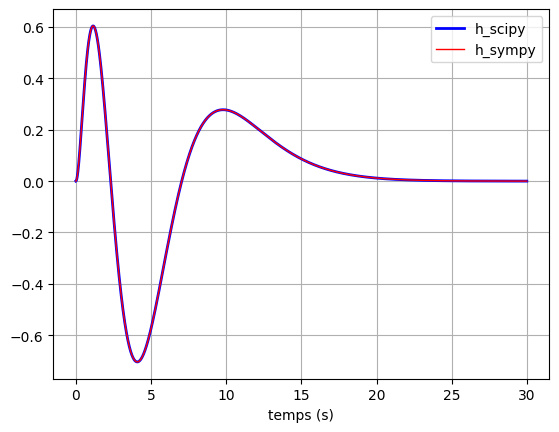

In [9]:
tps = np.arange(0, 30, 0.01)
_, h_scipy = impulse((coeffN, coeffD), T=tps)
h_sympy = np.real(sp.lambdify(t, h.subs(An).subs(Pn), 'numpy')(tps))
plt.plot(tps, h_scipy, 'b', lw=2, label='h_scipy')
plt.plot(tps, h_sympy, 'r', lw=1, label='h_sympy')
plt.grid('on')
plt.xlabel('temps (s)')
plt.legend()
plt.show()

## Méthodes de calcul

Voir la page Wikipédia [Décomposition en éléments simples](https://fr.wikipedia.org/w/index.php?title=D%C3%A9composition_en_%C3%A9l%C3%A9ments_simples) à la rubrique **Éléments simples associés à un pôle multiple**.
